In [ ]:
!pip install pysurvival
!pip install lifelines
!pip install osqp==0.5
!pip install scikit-survival
!pip install hyperopt

     |████████████████████████████████| 4.8MB 5.3MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp36-cp36m-linux_x86_64.whl size=3774877 sha256=5ce45274c5aff4c746636e71b197d199d1e57544975c2ee0f787c37a02c632b5
  Stored in directory: /root/.cache/pip/wheels/6c/23/e8/6feb0c4432219666bdd5d33828d7d9f429c4726f34c6fa8061
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12076 sha256=db215abc626448df773c0aea16bbfa8771f227a894c5a1970862acb619c8b350
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built pysurvival progressbar
     |████████████████████████████████| 348kB 5.4MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp36-none-any.whl size=4035 sha256=e8f9c7770fd7338a8eafd02418933edd76387721d6fdb1db80781fbfdd696a04
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gam

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as opt
from torch.distributions.weibull import Weibull
from torch.distributions.categorical import Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from lifelines.utils import concordance_index# as c_index
from sksurv.metrics import brier_score, integrated_brier_score, concordance_index_censored as ci_scikit
from hyperopt import hp
import hyperopt as ho
import dask
from copy import copy, deepcopy
%pylab inline
from google.colab import files
uploaded = files.upload()
#torch.cuda.set_device(0)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Saving telecom.csv to telecom.csv


In [ ]:
#https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu
seed = 7
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)
torch.cuda.is_available()

True

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
  # Make CuDNN Determinist
  torch.backends.cudnn.deterministic = True
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.benchmark = False

# Define default device, we should use the GPU (cuda) if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [ ]:
import io 
df = pd.read_csv(io.BytesIO(uploaded['telecom.csv']))
ids = df[['customerID']]
df.drop(columns=['customerID'], inplace=True)
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [ ]:
l = []
for j, i in enumerate(df['TotalCharges']):
    try:
        float(i)
    except ValueError:
        print(j, '_________', i)
        l.append(j)
df.drop(l, inplace = True ) 
df['TotalCharges'] = df['TotalCharges'].astype(float)
df = df.reset_index( drop = True )

488 _________  
753 _________  
936 _________  
1082 _________  
1340 _________  
3331 _________  
3826 _________  
4380 _________  
5218 _________  
6670 _________  
6754 _________  


In [ ]:
binary = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
categorical = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
numerical = ['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges']
df = pd.get_dummies(df, columns=binary, drop_first=True)
df = pd.get_dummies(df, columns=categorical)
# Creating the time and event columns
time_column = 'tenure'
event_column = 'Churn_Yes'
 
# Extracting the features
features = np.setdiff1d(df.columns, [time_column, event_column] ).tolist()

In [ ]:
from sklearn.model_selection import train_test_split

index_train, index_test = train_test_split(range(df.shape[0]), test_size=0.3, random_state=0, stratify=df['Churn_Yes'])

tmp_data_train = df.loc[index_train].reset_index( drop = True )
data_test  = df.loc[index_test].reset_index( drop = True )

index_train, index_valid = train_test_split(tmp_data_train.index, test_size=0.2, random_state=0, stratify=tmp_data_train['Churn_Yes'])
data_train = tmp_data_train.loc[index_train].reset_index( drop = True )
data_valid = tmp_data_train.loc[index_valid].reset_index( drop = True )

 
# Creating the X, T and E inputs
X_train, X_valid, X_test = data_train[features], data_valid[features], data_test[features]
T_train, T_valid, T_test = data_train[time_column], data_valid[time_column], data_test[time_column]
E_train, E_valid, E_test = data_train[event_column], data_valid[event_column], data_test[event_column]
 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(X_train[['MonthlyCharges', 'TotalCharges']])
scaled_valid = scaler.fit_transform(X_valid[['MonthlyCharges', 'TotalCharges']])
scaled_test = scaler.transform(X_test[['MonthlyCharges', 'TotalCharges']])
X_train[['MonthlyCharges', 'TotalCharges']], X_valid[['MonthlyCharges', 'TotalCharges']], X_test[['MonthlyCharges', 'TotalCharges']] = scaled_train, scaled_valid, scaled_test

X_train.shape, X_valid.shape, X_test.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


((3937, 39), (985, 39), (2110, 39))

In [ ]:
class NNModel(nn.Module):
    def __init__(self, input_shape, units=None, factors=None, dropout=None, slops=None):
        super().__init__()
        self.input_shape = input_shape
        self.units = units
        self.factors = factors
        self.network = nn.ModuleList()
        if self.factors:
            self.units = np.round(self.input_shape * np.asarray(self.factors)).astype(int)
        if self.units is not None:
            self.dropout = np.zeros_like(self.units) if dropout is None else dropout
            self.slops = np.full(len(self.units), 1) if slops is None else slops
            for i, j, k in zip(self.units, self.dropout, self.slops):
                if i >= 1:
                    block = self.__build_block__(input_shape, i, p=j, slop=k)
                    self.network.extend(block)
                    input_shape = i
        self.output_shape = input_shape
        self.reset_parameters()
    
    def __build_block__(self, input_shape, units, p, slop, norm=False):
        block = []
        block.append(nn.Linear(input_shape, units, bias=not norm))
        if norm:
            block.append(nn.BatchNorm1d(units))
        block.append(nn.ELU(slop))
        if p > 0:
            block.append(nn.Dropout(p))
        return block
 
    def forward(self, x):
        for layer in self.network:
          tmp = layer(x)
          x = tmp
        return x
 
    def reset_parameters(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight)

class MWN(nn.Module):
    def __init__(self, shared, clf_nn, alpha_nn, beta_nn, n_comp):
        super(MWN, self).__init__()
        self.shared = shared
        self.clf_nn = clf_nn
        self.alpha_nn = alpha_nn
        self.beta_nn = beta_nn
        self.n_comp = n_comp
        self.pi = nn.Linear(self.clf_nn.output_shape, self.n_comp)
        self.ai = nn.Linear(self.alpha_nn.output_shape, self.n_comp)
        self.bi = nn.Linear(self.beta_nn.output_shape, self.n_comp)
        
    def forward(self, x):
        z = self.shared(x)
        x = torch.cat((x, z), 1)
        pi = nn.Softmax(dim=-1)(self.pi(self.clf_nn(x)))
        '''beta = torch.exp(self.bi(self.beta_nn(x))) + 1
        alpha = torch.exp(self.ai(self.alpha_nn(x))) + 1e-5'''
        beta = nn.ELU()(self.bi(self.beta_nn(x))) + 2
        alpha = nn.ELU()(self.ai(self.alpha_nn(x))) + 1 + 1e-5
        return pi, beta, alpha

class DeepWeiSurv:
    def __init__(self, model, num_time_bins, resume=None):
        self.model = model
        self.losses = {'Epoch': [], 'Train': [], 'Test': [], 'State': [], 'optimizer_state_dict': []}
        self.num_time_bins = num_time_bins
        self.times = None
        self.optim = resume

    def process_data(self, data, time, event):
        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []
        T_cens, T_uncens = [], []
        for i, e in enumerate(event):
            if e == 1: #not censored              
                X_uncens.append(data[i,:]), Y_uncens.append(e), T_uncens.append(time[i])
            else:
                X_cens.append(data[i,:]), Y_cens.append(e), T_cens.append(time[i])
        #return torch.FloatTensor(np.asarray(X_uncens)), torch.FloatTensor(np.asarray(Y_uncens)), torch.FloatTensor(np.asarray(T_uncens)[:,np.newaxis]), torch.FloatTensor(np.asarray(X_cens)), torch.FloatTensor(np.asarray(Y_cens)), torch.FloatTensor(np.asarray(T_cens)[:,np.newaxis])
        #return torch.FloatTensor(np.asarray(X_uncens)), torch.FloatTensor(np.asarray(Y_uncens)), torch.FloatTensor(self.times[:,np.newaxis,np.newaxis]), torch.FloatTensor(np.asarray(X_cens)), torch.FloatTensor(np.asarray(Y_cens)), torch.FloatTensor(np.asarray(T_cens))
        return torch.FloatTensor(np.asarray(X_uncens)), torch.FloatTensor(np.asarray(Y_uncens)), torch.FloatTensor(np.asarray(T_uncens)), torch.FloatTensor(np.asarray(X_cens)), torch.FloatTensor(np.asarray(Y_cens)), torch.FloatTensor(np.asarray(T_cens))

    """def loss_function(self, X_uncens, T_uncens, X_cens, T_cens, l2_reg):
        pi, beta, alpha = self.model(X_uncens)
        pdf = torch.exp(Weibull(alpha, beta, validate_args=None).log_prob(T_uncens)) + 1e-35
        ll1 = torch.sum(torch.log(torch.sum(pi * pdf, dim=-1)))
        
        pi, beta, alpha = self.model(X_cens)
        surv = 1 - Weibull(alpha, beta, validate_args=None).cdf(T_cens) + 1e-35
        ll2 = torch.sum(torch.log(torch.sum(pi * surv, dim=-1)))
        loss = -(ll1 + ll2)
        '''for w in self.model.parameters():
            loss += l2_reg*torch.sum(w*w)/2.'''
        return loss"""

    def loss_function(self, X_uncens, T_uncens, X_cens, T_cens, l2_reg):
        pi, beta, alpha = self.model(X_uncens)
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)
        pdf = MixtureSameFamily(mix, comp).log_prob(T_uncens)
        ll1 = torch.mean(pdf)
        
        pi, beta, alpha = self.model(X_cens)
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)
        surv = torch.clamp(1 - MixtureSameFamily(mix, comp).cdf(T_cens), min=1e-25)
        ll2 = torch.mean(torch.log(surv))
        loss = -(ll1 + ll2)
        return loss

    def train_model(self, optim, X_uncens, T_uncens, X_cens, T_cens, l2_reg, i):
        self.optim.zero_grad()
        self.model = self.model.train()
        loss = self.loss_function(X_uncens, T_uncens, X_cens, T_cens, l2_reg)
        loss.backward()
        #max_grad = 0.05 if i > 40 else 5
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 10)
        self.optim.step()
        return loss.item()
 
    def eval_model(self,X_uncens, T_uncens, X_cens, T_cens, l2_reg):
        self.model = self.model.eval()
        loss = self.loss_function(X_uncens, T_uncens, X_cens, T_cens, l2_reg)
        return loss.item()
 
    def fit(self, X_train, T_train, E_train, epoch, lr, batch_size=512, factor=0.5, patience=15, momentum=0.9, is_min_time_zero=False, extra_pct_time=0.1,
            X_test=None, T_test=None, E_test=None, l2_reg=1e-2, eval=True, verbose=True):
        
        min_t = 0 if is_min_time_zero else min(T_train)
        max_t = max(T_train)*(1+extra_pct_time)
        self.times = np.linspace(min_t, max_t, self.num_time_bins)

        X_train_uncens, Y_train_uncens, T_train_uncens, X_train_cens, Y_train_cens, T_train_cens = self.process_data(X_train, T_train, E_train)
        if X_test is not None:
            X_test_uncens, Y_test_uncens, T_test_uncens, X_test_cens, Y_test_cens, T_test_cens = self.process_data(X_test, T_test, E_test)

        best_loss = 1e100
        '''self.optim = opt.Adam(self.model.parameters(), lr=lr)
        scheduler = None'''
        self.optim = opt.SGD(self.model.parameters(), lr=lr, momentum=momentum, nesterov=True)
        scheduler = opt.lr_scheduler.CyclicLR(self.optim, 1e-5, lr, 200, 200)
        #scheduler = opt.lr_scheduler.ReduceLROnPlateau(self.optim, mode='min', factor=factor, patience=patience, verbose=verbose, eps=0, min_lr=1e-5)
        #scheduler = None#opt.lr_scheduler.MultiStepLR(self.optim, milestones=[28, 120], gamma=0.1)

        eval_score = ''
        for i in range(epoch):
            if verbose:
              print('##### EPOCH '+str(i) + ' #####')
            train_loss = self.train_model(self.optim, X_train_uncens, T_train_uncens, X_train_cens, T_train_cens, l2_reg, i)
            if np.isnan(train_loss) or np.isinf(train_loss):
                print('Stop training')
                break
            if verbose:
              print('train loss : ' ,train_loss)

            '''if train_loss < 11 :
                for g in optim.param_groups:
                    g['lr'] = g['lr'] * 0.01
            print(optim.param_groups[0]['lr'])'''

            self.losses['Epoch'].append(i), self.losses['Train'].append(train_loss)
            
            if X_test is not None:
                test_loss = self.eval_model(X_test_uncens, T_test_uncens, X_test_cens, T_test_cens, l2_reg)
                #metric = self.c_index(X_test, T_test, E_test)
                if eval:
                    _, eval_score = self.b_index(X_train, T_train, E_train, X_test, T_test, E_test, plot=False)
                if test_loss<best_loss:
                    self.losses['State'] = deepcopy(self.model.state_dict())
                    best_loss = test_loss
                    if verbose:
                      print('test loss : ' ,test_loss, ' _______ Metric : ', eval_score)
                      print('===========SAVE===========')
                self.losses['Test'].append(test_loss)
                if scheduler is not None:
                    #scheduler.step(test_loss)
                    scheduler.step()
                    #print(scheduler.get_last_lr())


    def prdict_survival(self, X, T):
      X = torch.tensor(X.astype(np.float32))
      T = torch.FloatTensor(self.times[:,np.newaxis,np.newaxis])
      pi, beta, alpha = self.model(X)
      mix = Categorical(pi)
      comp = Weibull(alpha, beta, validate_args=None)
      surv = 1 - MixtureSameFamily(mix, comp).cdf(T)
      return pi, beta, alpha, surv

    def c_index(self, p, alpha, beta, t, e):
        mlt = torch.sum(pi * alpha * torch.lgamma(1 + (1/beta)).exp(), 1).data.numpy()
        res = 1 - ci_scikit(e.astype(np.bool), t, mlt)[0]
        return res, mlt

    def b_index(self, X_train, T_train, E_train, X_test, T_test, E_test, survival, plot=True):
        time_idx = self.times[np.argmin(self.times<min(T_test)):np.argmax(self.times>max(T_test)) - 1] #don't keep times index that are beyond max(T_train)
        train_e_t = np.asarray(list(zip(E_train.astype(np.bool), T_train)), dtype='|bool, i4') #concat event and time
        test_e_t = np.asarray(list(zip(E_test.astype(np.bool), T_test)), dtype='|bool, i4')
        brier_res = []
        for j, i in enumerate(time_idx):
            _, score = brier_score(train_e_t, test_e_t, survival[:,j], i)
            brier_res.append(score[0])
        ibs = np.trapz(brier_res, time_idx)/max(T_train)
        if plot:
            figure = self.plot_brier_curve(time_idx, brier_res, ibs)
            return brier_res, ibs, figure
        else:
            return brier_res, ibs
 
    def plot_brier_curve(self, time_axis, score, ibs):
        fig, ax = plt.subplots(figsize=(8, 4))
        plt.plot(time_axis, score, color='blue', label='Brier score / time', lw=2)

        plt.axhline(y=0.25, color='black', linestyle='-')
        #ax.annotate('0.25', xy=(1, 0.5), xytext=(t, 0.5), fontsize=12)

        title = "Integrated Brier Score: " + str(ibs)
        plt.legend(fontsize=12)
        plt.title(title, fontsize=15)
        plt.ylim(0, 1.05)
        return plt

In [ ]:
'''
train loss :  1894.7987060546875
test loss :  220.49636840820312

n_comp, epoch, lr, batch_size, d = 3, 15000, 1e-7, 512, 0.

shared_nn = NNModel(X_train.shape[1], units=[180, 190, 250, 310], factors=None, dropout=[d, d, d, d])
clf_nn = NNModel(shared_nn.output_shape, units=[360, 390], factors=None, dropout=[d, d])
alpha_nn = NNModel(shared_nn.output_shape, units=[590, 610], factors=None, dropout=[d, d])
beta_nn = NNModel(shared_nn.output_shape, units=[590, 610], factors=None, dropout=[d, d])
nn_model = MWN(shared_nn, clf_nn, alpha_nn, beta_nn, n_comp)
#print(nn_model)
dws = DeepWeiSurv(nn_model, 80)
dws.fit(X_train.values, T_train.values, E_train.values, epoch, lr, batch_size=512, factor=0.5, patience=15, momentum=0.9, X_test=X_valid.values, T_test=T_valid.values, E_test=E_valid.values, 
        l2_reg=1e-2, eval=False, verbose=True)'''

n_comp, epoch, lr, batch_size, d = 1, 5000, 1e-2, 512, 0.

shared_nn = NNModel(X_train.shape[1], units=[150, 280, 310, 320], factors=None)
clf_nn = NNModel(shared_nn.output_shape + X_train.shape[1], units=[1], factors=None)
alpha_nn = NNModel(shared_nn.output_shape + X_train.shape[1], units=[590, 610], factors=None)
beta_nn = NNModel(shared_nn.output_shape + X_train.shape[1], units=[590, 610], factors=None)#, dropout=[d,d,d,d]
nn_model = MWN(shared_nn, clf_nn, alpha_nn, beta_nn, n_comp)
#nn_model.load_state_dict(best_state)
#print(nn_model)
dws = DeepWeiSurv(nn_model, 100)
dws.fit(X_train.values, T_train.values, E_train.values, epoch, lr, batch_size=512, factor=0.5, patience=50, momentum=0.9, X_test=X_valid.values, T_test=T_valid.values, E_test=E_valid.values, 
        l2_reg=1e-2, eval=False, verbose=True)

#https://stackoverflow.com/questions/48324152/pytorch-how-to-change-the-learning-rate-of-an-optimizer-at-any-given-moment-no

##### EPOCH 0 #####
train loss :  154.83428955078125
test loss :  274.36468505859375  _______ Metric :  
===========SAVE===========
##### EPOCH 1 #####
train loss :  153.202880859375
test loss :  234.8694610595703  _______ Metric :  
===========SAVE===========
##### EPOCH 2 #####
train loss :  140.5079345703125
test loss :  172.71624755859375  _______ Metric :  
===========SAVE===========
##### EPOCH 3 #####
train loss :  118.2679672241211
test loss :  118.5687255859375  _______ Metric :  
===========SAVE===========
##### EPOCH 4 #####
train loss :  94.72950744628906
test loss :  84.79736328125  _______ Metric :  
===========SAVE===========
##### EPOCH 5 #####
train loss :  76.21492004394531
test loss :  66.10502624511719  _______ Metric :  
===========SAVE===========
##### EPOCH 6 #####
train loss :  63.625755310058594
test loss :  55.17909240722656  _______ Metric :  
===========SAVE===========
##### EPOCH 7 #####
train loss :  54.502342224121094
test loss :  47.25678253173828  _____

KeyboardInterrupt: ignored

In [ ]:
class NNModel(nn.Module):
    def __init__(self, input_shape, units=None, factors=None, dropout=None, slops=None):
        super().__init__()
        self.input_shape = input_shape
        self.units = units
        self.factors = factors
        self.network = nn.ModuleList()
        if self.factors:
            self.units = np.round(self.input_shape * np.asarray(self.factors)).astype(int)
        if self.units is not None:
            self.dropout = np.zeros_like(self.units) if dropout is None else dropout
            self.slops = np.full(len(self.units), 1) if slops is None else slops
            for i, j, k in zip(self.units, self.dropout, self.slops):
                if i >= 1:
                    block = self.__build_block__(input_shape, i, p=j, slop=k)
                    self.network.extend(block)
                    input_shape = i
        self.output_shape = input_shape
        self.reset_parameters()
    
    def __build_block__(self, input_shape, units, p, slop, norm=False):
        block = []
        block.append(nn.Linear(input_shape, units, bias=not norm))
        if norm:
            block.append(nn.BatchNorm1d(units))
        block.append(nn.ELU(slop))
        if p > 0:
            block.append(nn.Dropout(p))
        return block
 
    def forward(self, x):
        for layer in self.network:
          tmp = layer(x)
          x = tmp
        return x
 
    def reset_parameters(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)

class MWN(nn.Module):
    def __init__(self, shared, clf_nn, alpha_nn, beta_nn, n_comp):
        super(MWN, self).__init__()
        self.shared = shared
        self.clf_nn = clf_nn
        self.alpha_nn = alpha_nn
        self.beta_nn = beta_nn
        self.n_comp = n_comp
        self.pi = nn.Linear(self.clf_nn.output_shape, self.n_comp)
        self.ai = nn.Linear(self.alpha_nn.output_shape, self.n_comp)
        self.bi = nn.Linear(self.beta_nn.output_shape, self.n_comp)
        
    def forward(self, x):
        z = self.shared(x)
        x = torch.cat((x, z), 1)
        pi = nn.Softmax(dim=-1)(self.pi(self.clf_nn(x)))
        '''beta = torch.exp(self.bi(self.beta_nn(x))) + 1
        alpha = torch.exp(self.ai(self.alpha_nn(x))) + 1e-5'''
        beta = nn.ELU()(self.bi(self.beta_nn(x))) + 2
        alpha = nn.ELU()(self.ai(self.alpha_nn(x))) + 1 + 1e-5
        return pi, beta, alpha

class DeepWeiSurv:
    def __init__(self, model, num_time_bins, resume=None):
        self.model = model
        self.losses = {'Epoch': [], 'Train': [], 'Test': [], 'State': [], 'LR': []}
        self.num_time_bins = num_time_bins
        self.times = None
        self.optim = resume

    def process_data(self, data, time, event):
        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []
        T_cens, T_uncens = [], []
        for i, e in enumerate(event):
            if e == 1: #not censored              
                X_uncens.append(data[i,:]), Y_uncens.append(e), T_uncens.append(time[i])
            else:
                X_cens.append(data[i,:]), Y_cens.append(e), T_cens.append(time[i])
        #return torch.FloatTensor(np.asarray(X_uncens)), torch.FloatTensor(np.asarray(Y_uncens)), torch.FloatTensor(np.asarray(T_uncens)[:,np.newaxis]), torch.FloatTensor(np.asarray(X_cens)), torch.FloatTensor(np.asarray(Y_cens)), torch.FloatTensor(np.asarray(T_cens)[:,np.newaxis])
        #return torch.FloatTensor(np.asarray(X_uncens)), torch.FloatTensor(np.asarray(Y_uncens)), torch.FloatTensor(self.times[:,np.newaxis,np.newaxis]), torch.FloatTensor(np.asarray(X_cens)), torch.FloatTensor(np.asarray(Y_cens)), torch.FloatTensor(np.asarray(T_cens))
        return torch.FloatTensor(np.asarray(X_uncens)), torch.FloatTensor(np.asarray(Y_uncens)), torch.FloatTensor(np.asarray(T_uncens)), torch.FloatTensor(np.asarray(X_cens)), torch.FloatTensor(np.asarray(Y_cens)), torch.FloatTensor(np.asarray(T_cens))

    """def loss_function(self, X_uncens, T_uncens, X_cens, T_cens, l2_reg):
        pi, beta, alpha = self.model(X_uncens)
        pdf = torch.exp(Weibull(alpha, beta, validate_args=None).log_prob(T_uncens)) + 1e-35
        ll1 = torch.sum(torch.log(torch.sum(pi * pdf, dim=-1)))
        
        pi, beta, alpha = self.model(X_cens)
        surv = 1 - Weibull(alpha, beta, validate_args=None).cdf(T_cens) + 1e-35
        ll2 = torch.sum(torch.log(torch.sum(pi * surv, dim=-1)))
        loss = -(ll1 + ll2)
        '''for w in self.model.parameters():
            loss += l2_reg*torch.sum(w*w)/2.'''
        return loss"""

    def loss_function(self, X_uncens, T_uncens, X_cens, T_cens, l2_reg):
        pi, beta, alpha = self.model(X_uncens)
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)
        pdf = MixtureSameFamily(mix, comp).log_prob(T_uncens)
        ll1 = torch.mean(pdf)
        
        pi, beta, alpha = self.model(X_cens)
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)
        surv = torch.clamp(1 - MixtureSameFamily(mix, comp).cdf(T_cens), min=1e-25)
        ll2 = torch.mean(torch.log(surv))
        loss = -(ll1 + ll2)
        return loss

    def train_model(self, optim, X_uncens, T_uncens, X_cens, T_cens, l2_reg, i):
        self.optim.zero_grad()
        self.model = self.model.train()
        loss = self.loss_function(X_uncens, T_uncens, X_cens, T_cens, l2_reg)
        loss.backward()
        #max_grad = 0.05 if i > 40 else 5
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 10)
        self.optim.step()
        return loss.item()
 
    def eval_model(self,X_uncens, T_uncens, X_cens, T_cens, l2_reg):
        self.model = self.model.eval()
        loss = self.loss_function(X_uncens, T_uncens, X_cens, T_cens, l2_reg)
        return loss.item()
 
    def fit(self, X_train, T_train, E_train, epoch, lr, opt_kwarg, batch_size=512,  momentum=0.9, is_min_time_zero=False, extra_pct_time=0.1,
            X_test=None, T_test=None, E_test=None, l2_reg=1e-2, eval=True, verbose=True, save=True):
        
        min_t = 0 if is_min_time_zero else min(T_train)
        max_t = max(T_train)*(1+extra_pct_time)
        self.times = np.linspace(min_t, max_t, self.num_time_bins)

        X_train_uncens, Y_train_uncens, T_train_uncens, X_train_cens, Y_train_cens, T_train_cens = self.process_data(X_train, T_train, E_train)
        if X_test is not None:
            X_test_uncens, Y_test_uncens, T_test_uncens, X_test_cens, Y_test_cens, T_test_cens = self.process_data(X_test, T_test, E_test)

        best_loss = 1e100
        '''self.optim = opt.Adam(self.model.parameters(), lr=lr)
        scheduler = None'''
        self.optim = opt.SGD(self.model.parameters(), lr=lr, momentum=momentum, nesterov=True)
        scheduler = opt.lr_scheduler.CyclicLR(self.optim, **opt_kwarg)
        #scheduler = opt.lr_scheduler.ReduceLROnPlateau(self.optim, **opt_kwarg)
        #scheduler = opt.lr_scheduler.MultiStepLR(self.optim, milestones=[28, 120], gamma=0.1)

        eval_score = ''
        for i in range(epoch):
            if verbose:
              print('##### EPOCH '+str(i) + ' #####')
            train_loss = self.train_model(self.optim, X_train_uncens, T_train_uncens, X_train_cens, T_train_cens, l2_reg, i)
            if np.isnan(train_loss) or np.isinf(train_loss):
                print('Stop training')
                break
            if verbose:
              print('train loss : ' ,train_loss)

            '''if train_loss < 11 :
                for g in optim.param_groups:
                    g['lr'] = g['lr'] * 0.01
            print(optim.param_groups[0]['lr'])'''

            self.losses['Epoch'].append(i), self.losses['Train'].append(train_loss)
            
            if X_test is not None:
                test_loss = self.eval_model(X_test_uncens, T_test_uncens, X_test_cens, T_test_cens, l2_reg)
                #metric = self.c_index(X_test, T_test, E_test)
                if eval:
                    _, eval_score = self.b_index(X_train, T_train, E_train, X_test, T_test, E_test, plot=False)
                if save and (test_loss<best_loss):
                    self.losses['State'] = deepcopy(self.model.state_dict())
                    best_loss = test_loss
                    if verbose:
                      print('===========SAVE===========')

                if verbose:
                      print('test loss : ' ,test_loss, ' _______ Metric : ', eval_score)

                self.losses['Test'].append(test_loss)
                if scheduler is not None:
                    #scheduler.step(test_loss)
                    scheduler.step()
                    #print(scheduler.get_last_lr())
                    self.losses['LR'].append(scheduler.get_last_lr()[0])


    def prdict_survival(self, X):
        X = torch.tensor(X.astype(np.float32))
        T = torch.FloatTensor(self.times[:,np.newaxis,np.newaxis])
        pi, beta, alpha = self.model(X)
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)
        surv = 1 - MixtureSameFamily(mix, comp).cdf(T)
        return pi, beta, alpha, surv

    def c_index(self, p, alpha, beta, t, e):
        mlt = torch.sum(pi * alpha * torch.lgamma(1 + (1/beta)).exp(), 1).data.numpy()
        res = 1 - ci_scikit(e.astype(np.bool), t, mlt)[0]
        return res, mlt

    def b_index(self, X_train, T_train, E_train, X_test, T_test, E_test, survival, plot=True):
        time_idx = self.times[np.argmin(self.times<min(T_test)):np.argmax(self.times>max(T_test)) - 1] #don't keep times index that are beyond max(T_train)
        train_e_t = np.asarray(list(zip(E_train.astype(np.bool), T_train)), dtype='|bool, i4') #concat event and time
        test_e_t = np.asarray(list(zip(E_test.astype(np.bool), T_test)), dtype='|bool, i4')
        brier_res = []
        for j, i in enumerate(time_idx):
            _, score = brier_score(train_e_t, test_e_t, survival[:,j], i)
            brier_res.append(score[0])
        ibs = np.trapz(brier_res, time_idx)/max(T_train)
        if plot:
            figure = self.plot_brier_curve(time_idx, brier_res, ibs)
            return brier_res, ibs, figure
        else:
            return brier_res, ibs
 
    def plot_brier_curve(self, time_axis, score, ibs):
        fig, ax = plt.subplots(figsize=(8, 4))
        plt.plot(time_axis, score, color='blue', label='Brier score / time', lw=2)

        plt.axhline(y=0.25, color='black', linestyle='-')
        #ax.annotate('0.25', xy=(1, 0.5), xytext=(t, 0.5), fontsize=12)

        title = "Integrated Brier Score: " + str(ibs)
        plt.legend(fontsize=12)
        plt.title(title, fontsize=15)
        plt.ylim(0, 1.05)
        return plt

n_comp, epoch, lr, batch_size, d = 1, 25000, 1e-5, 512, 0.7
cyclic_kwarg = {'base_lr': lr, 'max_lr': 1e-2, 'step_size_up':200, 'step_size_down':200}
#plateau_kwarg = {'factor':0.5, 'patience':50, 'verbose':True, 'min_lr':1e-7, 'mode':'min'}

shared_nn = NNModel(X_train.shape[1], units=[150, 280, 310, 320], factors=None)
clf_nn = NNModel(shared_nn.output_shape + X_train.shape[1], units=[1], factors=None)
alpha_nn = NNModel(shared_nn.output_shape + X_train.shape[1], units=[590, 610], factors=None)
beta_nn = NNModel(shared_nn.output_shape + X_train.shape[1], units=[590, 610], factors=None)#, dropout=[d,d,d,d]
nn_model = MWN(shared_nn, clf_nn, alpha_nn, beta_nn, n_comp)
#nn_model.load_state_dict(best_state)
#print(nn_model)
dws = DeepWeiSurv(nn_model, 100)
dws.fit(X_train.values, T_train.values, E_train.values, epoch, lr, cyclic_kwarg, batch_size=512, momentum=0.9, 
        X_test=X_valid.values, T_test=T_valid.values, E_test=E_valid.values, l2_reg=1e-2, eval=False, verbose=True, is_min_time_zero=True)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
train loss :  2.6991028785705566
test loss :  2.684873342514038  _______ Metric :  
##### EPOCH 2686 #####
train loss :  2.517055034637451
test loss :  2.746067523956299  _______ Metric :  
##### EPOCH 2687 #####
train loss :  2.6601250171661377
test loss :  2.6580703258514404  _______ Metric :  
##### EPOCH 2688 #####
train loss :  2.5100226402282715
test loss :  2.711566209793091  _______ Metric :  
##### EPOCH 2689 #####
train loss :  2.6458182334899902
test loss :  2.6574857234954834  _______ Metric :  
##### EPOCH 2690 #####
train loss :  2.495314359664917
test loss :  2.7150635719299316  _______ Metric :  
##### EPOCH 2691 #####
train loss :  2.6371078491210938
test loss :  2.63358998298645  _______ Metric :  
##### EPOCH 2692 #####
train loss :  2.4795494079589844
test loss :  2.6978070735931396  _______ Metric :  
##### EPOCH 2693 #####
train loss :  2.6294238567352295
test loss :  2.624871253967285  

KeyboardInterrupt: ignored

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=1)
fig.append_trace(go.Scatter(x=dws.losses['Epoch'][1100:], y=dws.losses['Train'][1100:],mode='lines',name='Train'), row=1, col=1)
fig.append_trace(go.Scatter(x=dws.losses['Epoch'][1100:], y=dws.losses['Test'][1100:],mode='lines',name='Test'), row=2, col=1)
fig.append_trace(go.Scatter(x=dws.losses['Epoch'][1100:], y=dws.losses['LR'][1100:],mode='lines',name='LR'), row=3, col=1)
fig.update_layout(height=1000, width=1500, title_text="Stacked Subplots")
fig.show()

In [ ]:
np.min(dws.losses['Test'])

1.6908679008483887

In [ ]:
#dws.losses['State'][-2]
best_state = deepcopy(dws.losses['State'])
dws.model.load_state_dict(best_state)

<All keys matched successfully>

In [ ]:
pi, beta, alpha, survival_predictions = dws.prdict_survival(X_test.values)
survival_predictions = np.squeeze(survival_predictions.data.numpy())
survival_predictions.shape

(100, 2110)

In [ ]:
beta.max()

tensor(41.2093, grad_fn=<MaxBackward1>)

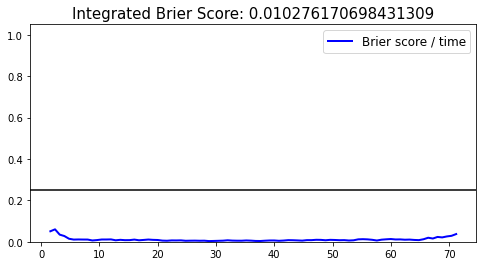

0.9868044065765992


In [ ]:
brier_res, ibs, figure = dws.b_index(X_train.values, T_train, E_train, X_test.values, T_test, E_test, survival_predictions.T, plot=True)
figure.show()
conc, mlt = dws.c_index(pi, alpha, beta, T_test, E_test)
print(conc)

In [ ]:
mlt

array([77.19432 , 66.478455, 48.42487 , ..., 87.32571 , 75.40968 ,
       17.69737 ], dtype=float32)

In [ ]:
from pysurvival.models.non_parametric import KaplanMeierModel

kmf = KaplanMeierModel()
kmf.fit(T_test, E_test)

T = torch.FloatTensor(dws.times[:,np.newaxis,np.newaxis])
mix = Categorical(pi)
comp = Weibull(alpha, beta, validate_args=None)
pdf = torch.sum(MixtureSameFamily(mix, comp).log_prob(T).exp(), (1,2)).data.numpy()

l = []
N = T_test.shape[0]
for i in dws.times:
    l.append(N*kmf.predict_density(i))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dws.times, y=pdf, mode='lines', name='predicted'))
fig.add_trace(go.Scatter(x=dws.times, y=l,mode='lines',name='actual'))
fig.show()

In [ ]:
data_test.loc[(data_test[event_column]==1) & (data_test[time_column]>=15) & (data_test[time_column]<=17)].index.values

array([ 130,  428,  467,  586,  644,  659,  706,  725,  797,  862,  867,
       1187, 1256, 1262, 1312, 1360, 1417, 1493, 1516, 1576, 1624, 1697,
       1719, 1848, 1865, 1869, 1872, 2003, 2040])

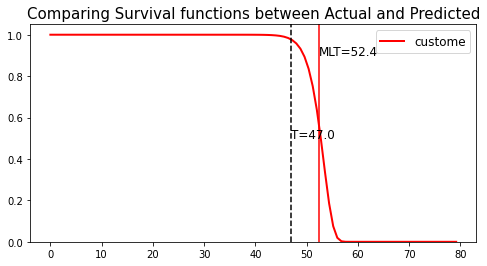

In [ ]:
k = 1188
t = T_test[k]
l_predicted = survival_predictions[:,k]
'''pys_predicted = lmtlr.predict_survival(X_test.iloc[[k]].values).flatten()
nmtlr_predicted = n_mtlr.predict_survival(X_test.iloc[[k]].values).flatten()'''

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(dws.times, l_predicted.flatten(), color='red', label='custome', lw=2)
'''plt.plot(lmtlr.times, pys_predicted, color='blue', label='pysurvival', lw=2)
plt.plot(n_mtlr.times, nmtlr_predicted, color='green', label='pysurvival nmtlr', lw=2)'''


plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=12)
plt.axvline(x=mlt[k], color='red', ls ='-')
ax.annotate('MLT={:.1f}'.format(mlt[k]), xy=(mlt[k], 0.5), xytext=(mlt[k], 0.9), fontsize=12)

# Show everything
title = "Comparing Survival functions between Actual and Predicted"
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()
# the probability that an individual within the population will survive longer than time t.
#Survival Function defines the probability that the event of interest has not occurred at time t 

In [ ]:
np.abs(T_test.values-mlt).argsort()[-500:][::-1]

array([1690, 1222, 1564, 1171, 1077,   95, 2094,  341, 1305,  625, 1009,
       1094, 1275,  499,  494, 1458,  360,  899, 1563, 1165, 1168,  734,
        460, 1500, 1231,  128, 1584, 1452, 2001,  515,  986,  580, 1255,
       2104, 1991, 1528, 2034, 1070, 2063, 1676, 1018,  187, 1098,  147,
        904, 1342,  226,  329,  807, 1806,  892, 2027,  280,  866, 1562,
       1291, 2065,   39, 1748, 1393, 1976, 1303,  893, 1181,  989,  332,
       1930, 1421, 1221,  802,  714,  101,  299,  692,  132,  136, 1494,
       1074, 2087,  126, 1884, 1660, 1861, 1762, 1059, 1244,  210,  920,
       1180, 1986,  979, 1551, 1525, 1241,  452,  952,  890,  646, 1644,
       1701, 1112,  162,  907, 1245,  334,  936,  410, 1253,  455,  555,
        627, 1620,  445,  896,  262, 1931, 1609, 1379,  612,   97, 1743,
         98, 1531,  318, 1814,  723, 1671,  872, 1414,  151, 1504, 1268,
       1020, 1529, 1073,  628, 1968,  245,  858,  947, 1638, 1225,   43,
        626,  192, 1902, 2107,  537,  614, 1549, 13

In [ ]:
float(alpha[k,0].data.numpy())

0.3128282427787781

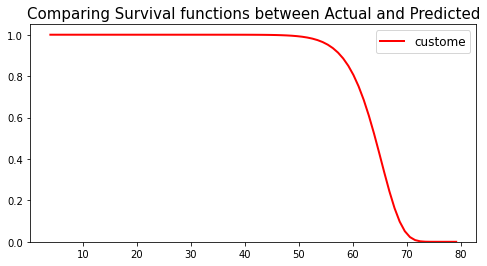

In [ ]:
d = torch.distributions.weibull.Weibull(65, 17, validate_args=None)
p = 0
#d = torch.distributions.weibull.Weibull(float(alpha[k,p].data.numpy()), float(beta[k,p].data.numpy()), validate_args=None)
t = np.linspace(4,79.2,80)
surv = 1 - d.cdf(dws.times)

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(t, surv.data.numpy().flatten(), color='red', label='custome', lw=2)


# Show everything
title = "Comparing Survival functions between Actual and Predicted"
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()
# the probability that an individual within the population will survive longer than time t.
#Survival Function defines the probability that the event of interest has not occurred at time t 

In [ ]:
d = Weibull(torch.tensor([[1.0, 3.3],[46.3, 119.21]]), torch.tensor([[5.0, 9.45], [45.8, 177.85]]), validate_args=None)
t = np.linspace(4,79.2,2)
t = t[:,np.newaxis]
d.log_prob(t)

In [ ]:
t

array([[ 4. ],
       [79.2]])

In [ ]:
d = Weibull(46.3, 45.8, validate_args=None)
t = np.linspace(4,79.2,2)
t = t[:,np.newaxis]
d.log_prob(79.2)

tensor(-4.7643e+10)

In [ ]:
from torch.distributions.independent import Independent

mix = Categorical(torch.tensor([[0.1, 0.40, 0.5], [0.5, 0.30, 0.2], [0.7, 0.25, 0.05], [0.8, 0.10, 0.1]]))
comp = Weibull(torch.tensor([[1.0, 3.3, 10.24],[46.3, 119.21, 11.54],[11.3, 32.21, 7.54],[90.3, 14.21, 71.54]]), 
               torch.tensor([[5.0, 9.45, 45.6], [45.8, 177.85, 250.6],[29.3, 37.21, 55.54],[101.3, 302.21, 70.54]]), validate_args=None)
mw = MixtureSameFamily(mix, comp)
t = torch.tensor(np.linspace(4,79.2,4))#
#t = t[:,np.newaxis]
mw.log_prob(t)

tensor([-4.3977e+00, -2.1561e+01, -2.4541e+08, -1.3264e+01],
       dtype=torch.float64)

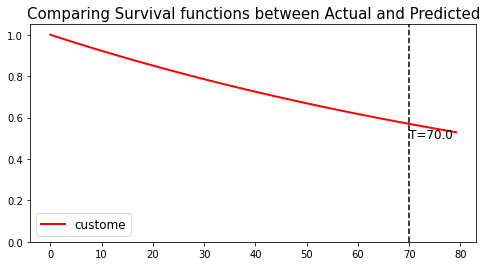

In [ ]:
from torch.distributions.independent import Independent

k=60
mix = Categorical(pi[k, :])
comp = Weibull(alpha[k,:], beta[k,:], validate_args=None)
mw = MixtureSameFamily(mix, comp)
t = torch.tensor(np.linspace(0,79.2,100)[:,np.newaxis,np.newaxis])
surv = 1 - mw.cdf(t)

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(torch.squeeze(t), surv.data.numpy().flatten(), color='red', label='custome', lw=2)

t = T_train[k]
plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=12)

# Show everything
title = "Comparing Survival functions between Actual and Predicted"
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()
# the probability that an individual within the population will survive longer than time t.
#Survival Function defines the probability that the event of interest has not occurred at time t 

In [ ]:
from google.colab import files
times = pd.DataFrame(dws.times)
times.to_csv('dws_times.csv')
files.download('dws_times.csv')

surv = pd.DataFrame(survival_predictions.T)
surv.to_csv('dws_telecom_surv_pred.csv')
files.download('dws_telecom_surv_pred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
mlt = pd.DataFrame(mlt)
mlt.to_csv('mlt.csv')
files.download('mlt.csv')
mlt

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,0
0,77.194321
1,66.478455
2,48.424870
3,80.043579
4,69.554848
...,...
2105,69.995796
2106,68.786926
2107,87.325706
2108,75.409683
